# Konzeption und Implementierung eines Multitasking Quartierenergiespeichers zur Erprobung eines wirtschaftlichen Speichermanagements
## Simulationsmodel - Maximilian Wiedemer
### Beispiel-Notebook

Dieses Beispiel-Notebook soll als kurze Einführung zur Bedienung des Simulationsmodels dienen. Es sollen im folgenden die einzelnen Schritte für das Laden der Daten bis hin zu einer beispielhaften Auswertung gezeigt werden. Mögliche Optionen und einstellbare Paramerter sollen erklärt werden.

Überprüfe die notwendigen Packages im Pipfile.  
Bei der Verwendung unter Windows empfiehlt sich die instalation des Packages noise über die whl: noise-1.2.3-cp38-cp38-win32.whl


### Schritte
1. Import
2. Laden der Daten
3. Erstellen des Simulationsmodels wählen der Parameter
4. Durchführung der Simulation
    1. (Optional) Erstellen der Fehler - Noise
    2.  Simulation starten
    3. Zuschneiden der LogDatei
    3.  Bewerten der Simulation
5. Speichern und laden von Simulationen
    1. Speichern
    2. Laden
6. Standard Auswertung - Visualisierung
7. weitere Visualisierungsvorschläge



### 1. Import
Importiert werden:
- SimModel  
Das Simulationsmodel
- Agent  
Der Agent
- Functions  
Funktionen unter anderem zur Standard Auswertung 
- pickle  
zum speicher und laden von Simulationen
- matplotlib.pyplot  
zum erstellen weiterer Visualisierungen

In [1]:
import SimModel
import Agent
import Functions as func

import pickle
import matplotlib.pyplot as plt
import numpy as np

### 2. Laden der Daten
Das laden der Daten funktioniert übedie Funktion:  

**Functions.getdata(timestart, timeend)**
- ***timestart***  
Angabe des ersten Tages der verwendeten Tage im Format 'MM-DD' als String
- ***timeend***  
Angabe des ersten Tages der verwendeten Tage im Format 'MM-DD' als String

- ***return***  
gibt folgende Datensätze zurück
    1. datafcr - PRL
    2. daraafrr - SRL
    3. datamfrr - Minutenreserve
    4. datalastprofile - Lastprofile
    5. pvdata - PV Leistung
    6. pricedata - Großhandelspreise

Die Datensätze Lastprofile, PV Leistung und Großhandelpreise sind im viertelstunden Takt aufgelöst und müssen entsprechend aufbereitet im Ordner Data abgelegt sein. Die Datensätze des Regelenergiemarktes sind entsprechend ihrer Produktzeitscheiben aufgelöst.

In [2]:
datafcr, dataafrr, datamfrr, datalastprofile, pvdata, pricedata = func.getdata('09-08','09-27')
# 08-02 08-21 09-08 09-27 11-09 11-28

### 3. Erstellen des Simulationsmodels
Der Klasse Model wird über ihr Konstruktor sowohl die Daten als auch die Simulationsparameter übergeben.

**SimModel.__init__(dataloadprofiles, listoflastprofiles, dataafrr, datafcr, pricedata, pvdata, numberofhouseswithpv, capacityofpvs,
                 capacityofenergystorage, agent)**
- ***dataloadprofiles***  
Datensatz der Lastprofile
- ***listoflastprofiles***  
Liste der Lastprofile, welche in der Simulation verwendet werden. Der Umfang der Liste gibt entsprechend auch die Anzahl der Haushalte im Simulationsmodell an.
- ***dataafrr***  
Datensatz der afrr Daten
- ***datafcr***  
Datensatz der fcr Daten
- ***pricedata***  
Datensatz der Großhandelspreise
- ***pvdata***  
Datensatz der PV Leistung
- ***numberofhousewithpv***  
Anzahl Häuser mit PV Anlage
- ***capacityofpvs***  
Größe der PV Anlagen
- ***capacityofenergystorage***  
Größe des Energiespeichers in KWh
- ***agent***  
Der Agent, in der Klasse Agent sind weiter Agenten implementier die teils aufeinander aufbauen.

In [3]:
agent = Agent.Agent()
#agent = Agent.Agent_manualinput()
lastprofile = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
model = SimModel.Model(datalastprofile, lastprofile, dataafrr, datafcr, pricedata, pvdata, 6, 5, 150, agent)

### 4. Durchführung der Simulation

Falls die Simulation mit Unsicherheit (Noise) durchgeführt werden soll, muss zuvor Art und Maß der Unsicherheut definiert werden.

#### 4.1 (Optional) Erstellen der Fehler - Noise

Die Noisefunktion bringt einen Forecast Fehler in die Simulation. Der Fehler wird als Faktor mit einem Erwartungswert von 1 auf die tatsächlichen Werte multipliziert. Die Unsicherheit wird für die PV-Daten und Last-Daten definiert.

**SimModel.def_noise(typeofnoice, stdlongpv, stdshortpv, stdlonglast, stdshortlast, logdata)**
- ***typeofnoice***  
Es kann zwischen "*gaussian*" und "*perlin*" gewählt werden. Der Perlin Noise ist ein gradientenbasierter Fehler, was zu natürlicherem bzw keiner sprunghaften Veränderung des Fehlers führt.
- ***stdlongpv***  
Std des Fehler für PV Daten bei einem Entscheidungshorizont größer 2 Tage
- ***stdshortpv***  
Std des Fehler für PV Daten bei einem Entscheidungshorizont kleiner 2 Tage
- ***stdlonglast***  
Std des Fehler für Last Daten bei einem Entscheidungshorizont größer 2 Tage
- ***stdshortlast***  
Std des Fehler für Last Daten bei einem Entscheidungshorizont kleiner 2 Tage
- ***logdata=self.logdata***  
Übergeben der Logdata, diese wird um die Spalten des Fehlers ergänzt

In [4]:
model.def_noise("perlin", 0.8, 0.4, 0.8, 0.4, model.logdata)

#### 4.2 Simulation starten  

Durch die Funktion Model.run wird die Simulation gestartet. Es werden alle Entscheidungen duchgeführt und ihre Auswirkung in der Logdatei mitgeschrieben.

**SimModel.run(ignoreprldecision=False, ignoresrldecision=False, showprogress=False, runwithtrading=False, runwithnoise=False)**
- ***ignoreprldecision=False***  
Falls auf "True" gesetzt wird nicht am PRL Markt patizipiert.
- ***ignoresrldecision=False***  
Falls auf "True" gesetzt wird nicht am SRL Markt patizipiert.
- ***showprogress=False***  
Falls auf "True" gesetzt wird während der Laufzeit regelmäßig ein Progress in die Console ausgegeben.
- ***runwithtrading=False***  
Falls am Strommarkt gehandelt werden soll. Implementiert mit perfekte Voraussicht. Änderung in Methode Model.addtrading() möglich
- ***runwithnoise=False***  
Falls auf "True", Simulation wird unter Unsicherheit durchgeführt. Zuvor muss wie in Schritt 4.1 beschrieben ein Fehler definiert werden.

In [5]:
model.run(showprogress = True, ignoreprldecision=False, ignoresrldecision=False, runwithnoise=False, runwithtrading=False)

Progress: 0%
Progress: 9%
Progress: 19%
Progress: 29%
Progress: 39%
Progress: 49%
Progress: 59%
Progress: 69%
Progress: 79%
Progress: 89%
Progress: 99%


#### 4.3 Zuschneiden der LogDatei

Am Ende der Simulation wird der Anfang und das Ende der Logdatei abgeschnitten. Hierdurch wird verhindert ermöglich das es bereits zum Start einen Speicherstand gibt und am Ende nur Entscheidungen einbegriffen werden bei denen die Gesamte entscheidung Durchführbar war. Bei PRL1 Entscheidungen beispielsweise werden wird ein weiter Tag nach dem Erbringungszeitraum benötigt. Je nach dem wieviele Tage die Agenten mit dem Speicher abdecken sollen werden mehr Tage benötigt. Als Standard werden zu Beginn der Simulation 2 Tage und am Ende der Simulation 3 Tage abgeschnitten. Dies gilt es beim einlesen der Daten zu beachten um später die gewünschte Simulationslänge zu erhalten.

**SimModel.cutlogdatei(start=192, end=289, includepricedatafortrading=False)**
- ***start=192***  
Anzahl Reihen die zu Beginn weggeschnitten werden sollen. 192 viertel Stunden entsprechen 2 Tagen
- ***end=289***  
Anzahl Reihen die am Ende weggeschnitten werden sollen. 1 mehr da die Logdatei mit Index 0 beginnt und die Anzahl von der Länge abgezogen wird
- ***includepricedatafortrading=False***  
Falls die Simulation mit Trading Task durchgeführt wird, müssen auch die Price Daten des Tradings angepasst werden.

In [6]:
model.cutlogdatei(includepricedatafortrading=False)

#### 4.4 Bewerten der Simulation

Nach dem die Simulation durchgeführt wurde und die Daten auf die Gewünschte Länge gekürz kann man das Ergebnis bewerten. Die Methode speicher das Ergebnis im Model ab (SimModel.valuedata) und gibt die Ergebnisse als Feld zurück.

**SimModel.evaluaterevenuestream()**  
- **return [valueselfconsumption, valuechargecapacity, valuefeedingrid, valuesrlcontrolenergy, valueprlcontrolenergy, valuetrading, valuesumme]**


In [7]:
data = model.evaluaterevenuestream()
data

[302.078995,
 15.214395000000007,
 17.692283333333332,
 11.038839999999997,
 775.9548000000001,
 0,
 1121.9793133333335]

### 5. Speichern und laden von Simulationen
Um eine Simulation zu speichern, speichern wir die Instanz des SimModels in einer Pickel Datei.

#### 5.1 speichern

In [8]:
#with open('SavedSimModel/test_pick.pkl', 'wb') as pickle_file:
#    pickle.dump(model, pickle_file)

#### 5.2 laden

In [9]:
#with open('SavedSimModel/test_pick.pkl', 'rb') as pickle_file:
#    model = pickle.load(pickle_file)

### 6. Standard Auswertung - Visualisierung

Einige standard Visualisierungen die Klasse Functions aufgerufen werden können. Hierzu wird das Simulationsmodel der Funktion übergeben

Setzt man den Index der Logdata zuvor auf den timestamp erscheint dieser auch als X-Achse

In [10]:
model.logdata = model.logdata.set_index('timestamp')

**Functions.plot_chargecapacity(model)**  
plot den Ladestand, gestackt und absolut

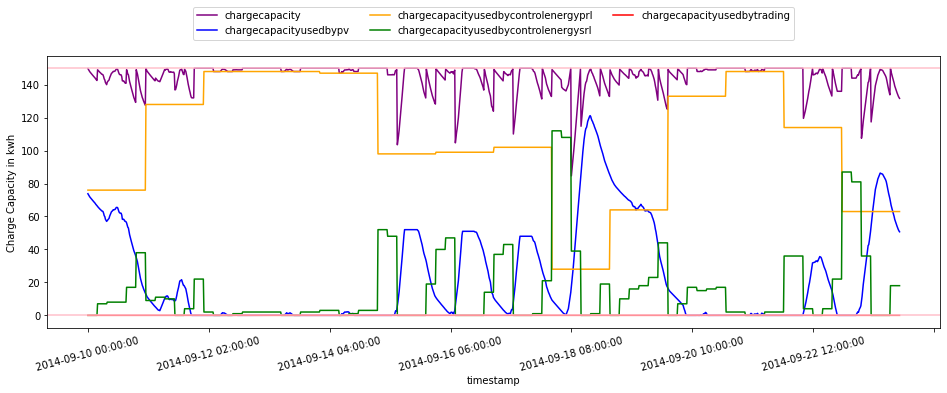

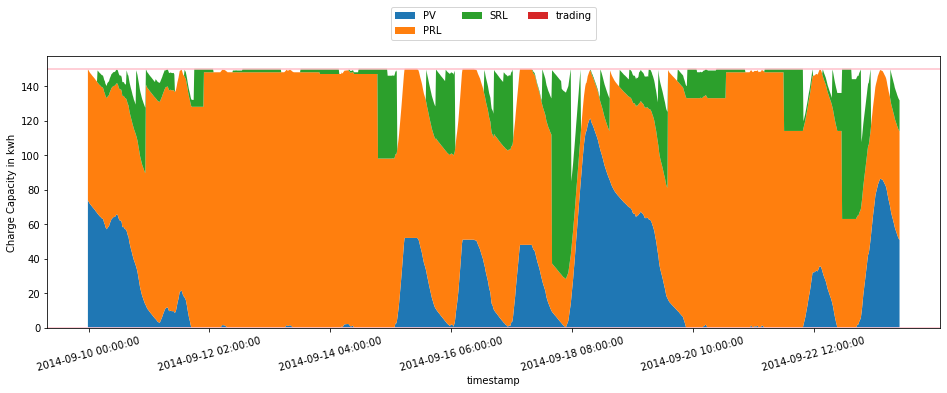

In [11]:
func.plot_chargecapacity(model)

**Functions.plot_revenuestreams(model)**  
plot die einezlenen revenues sowie die Summe

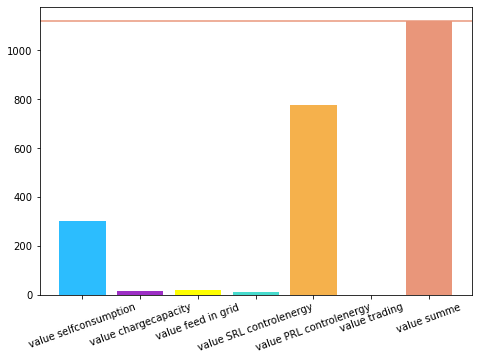

In [12]:
func.plot_revenuestreams(model)

**Functions.plot_revenuestreams(model)**  
plot die einezlenen revenues sowie die Summe

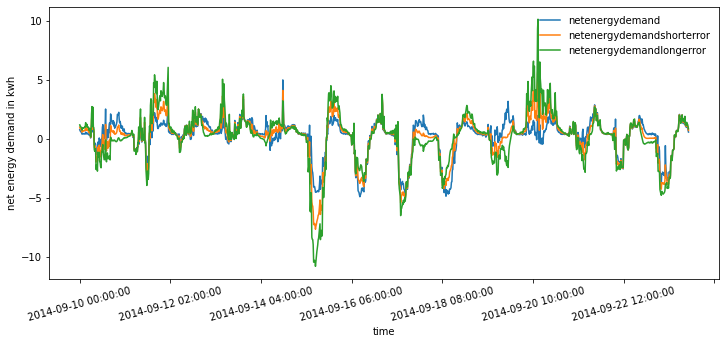

In [13]:
func.plot_error(model)

**Functions.plot_pvdata(model)**  
plot die pv daten

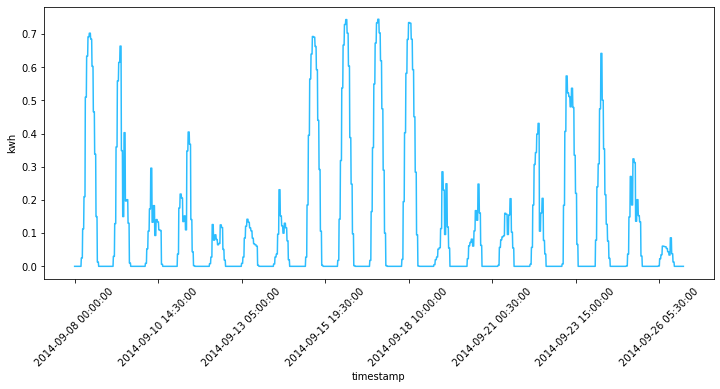

In [14]:
func.plot_pvdata(model)

**Functions.plot_lastprofile(model)**  
plot die last daten


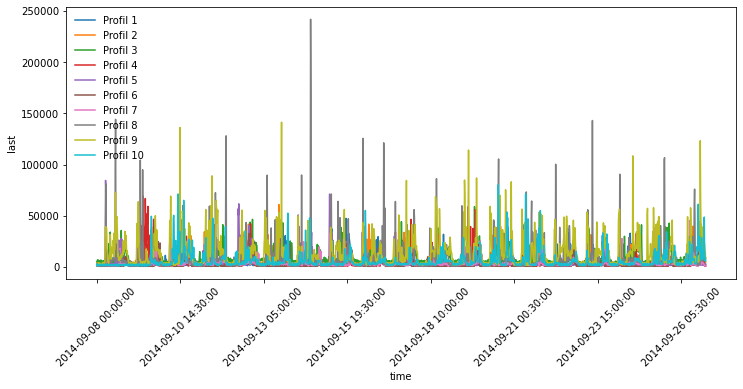

In [15]:
func.plot_lastprofiledata(model)

**Functions.plot_pricedata(model)**  
plot die pricedaten srl

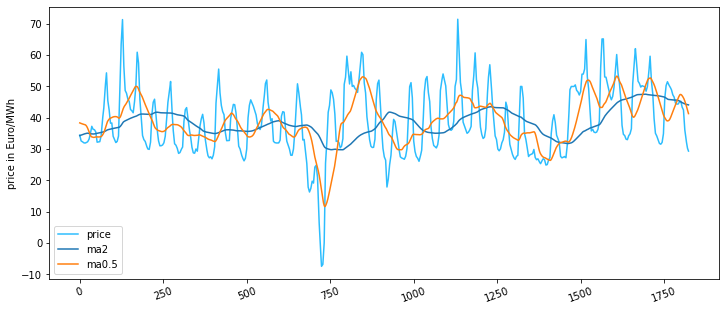

In [16]:
func.plot_pricedata(model)

**Functions.plot_primecontroldata(model)**  
plot die pricedaten prl

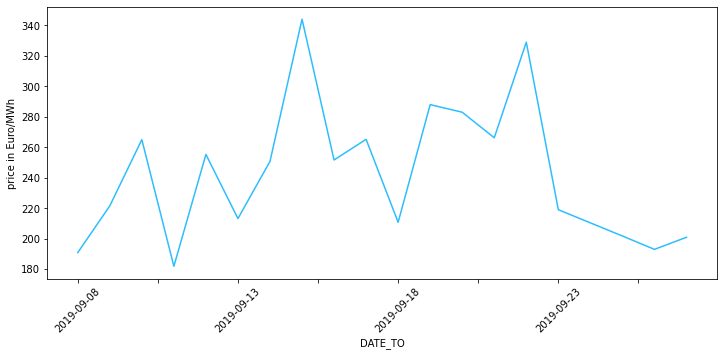

In [17]:
func.plot_primecontroldata(model)

**Functions.plot_secondcontrolenergy(model)**  
plot die pricedaten srl
- ***model***  
Simulationsmodel übergeben
- ***posorneg="NEG"***  
positiv oder negative srl ploten für positiv "POS" für negativ "NEG"

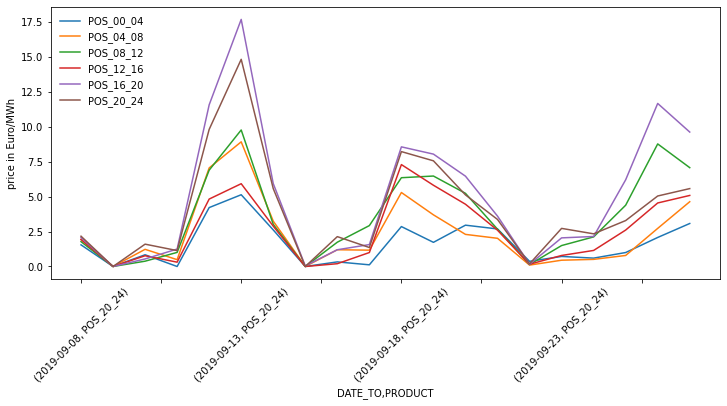

In [18]:
func.plot_secondcontrolenergy(model, "POS")

### 7. weitere Visualisierungsvorschläge

kumulierte Summen der Energie die vom Netz bezogen wird und der Energie die ins Netz gegeben wird.

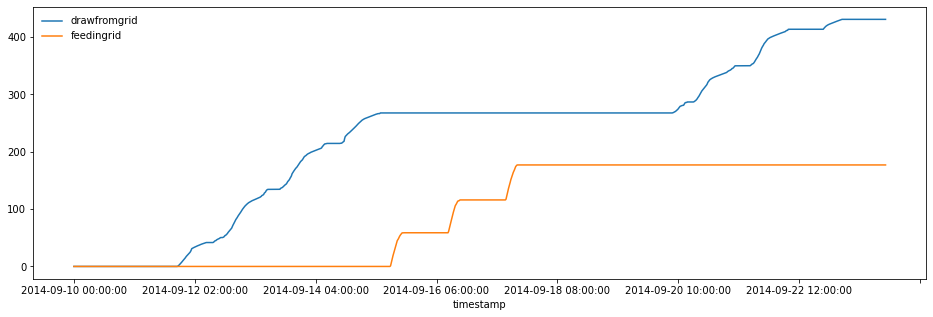

In [19]:
plt.figure(figsize=(16, 5))
cumsumdatadraw = model.logdata['drawfromgrid'].cumsum()
cumsumdatafeed = model.logdata['feedingrid'].cumsum()
cumsumdatadraw.plot()
cumsumdatafeed.plot()
plt.legend(loc='upper left', frameon=False)

**Vergleich Revenue verschiedener Simulationen**

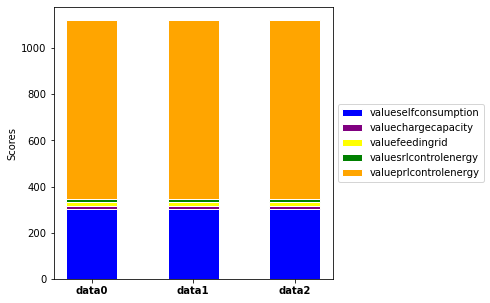

In [20]:
data0 = model.valuedata
data1 = model.valuedata
data2 = model.valuedata

bar1 =[data0[0], data1[0], data2[0]]
bar2 =[data0[1], data1[1], data2[1]]
bar3 =[data0[2], data1[2], data2[2]]
bar4 =[data0[3], data1[3], data2[3]]
bar5 =[data0[4], data1[4], data2[4]]

bars12 = np.add(bar1, bar2).tolist()
bars123 = np.add(bars12, bar3).tolist()
bars1234 = np.add(bars123, bar4).tolist()

r = [0, 1, 2]
plt.figure(figsize=(5, 5))
names = ['data0', 'data1', 'data2']
barWidth = 0.5
plt.bar(r, bar1, color='blue', edgecolor='white', width=barWidth, label="valueselfconsumption")
plt.bar(r, bar2, bottom=bar1, color='purple', edgecolor='white', width=barWidth, label="valuechargecapacity")
plt.bar(r, bar3, bottom=bars12, color='yellow', edgecolor='white', width=barWidth, label="valuefeedingrid")
plt.bar(r, bar4, bottom=bars123, color='green', edgecolor='white', width=barWidth,  label="valuesrlcontrolenergy")
plt.bar(r, bar5, bottom=bars1234, color='orange', edgecolor='white', width=barWidth,  label="valueprlcontrolenergy")
plt.xticks(r, names, fontweight='bold')
plt.ylabel('Scores')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [21]:
model.logdata.to_csv('test.csv')